In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Load dataset
df = pd.read_csv('dataset.csv')

# Null value analysis
print("Null values per column:")
print(df.isnull().sum())

Null values per column:
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [18]:
# Prepare features and target
X = df.drop(['id', 'NObeyesdad'], axis=1)
y = df['NObeyesdad']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
def analyze_and_impute_missing_values(df):
    print("Null values per column:")
    print(df.isnull().sum())
    # Impute missing values (numerical: mean, categorical: mode)
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    print("Null values after imputation:")
    print(df.isnull().sum())

In [20]:
def analyze_data_biasness(df):
    """
    Analyze data skewness for each numerical feature and plot distributions.
    """
    print("Data Skewness Analysis:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    skewness = df[numeric_cols].skew()
    print(skewness)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=skewness.index, y=skewness.values)
    plt.title('Skewness of Numerical Features')
    plt.ylabel('Skewness')
    plt.xticks(rotation=45)
    plt.show()

In [21]:
def analyze_decision_tree(X_train, X_test, y_train, y_test):
    best_acc = 0
    best_params = {}
    best_metrics = {}
    print("Decision Tree parameter tuning:")
    for max_depth in [3, 5, 10, None]:
        for min_samples_split in [2, 5, 10]:
            dt = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split)
            dt.fit(X_train, y_train)
            dt_pred = dt.predict(X_test)
            acc = accuracy_score(y_test, dt_pred)
            report = classification_report(y_test, dt_pred, output_dict=True)
            precision = report['weighted avg']['precision']
            recall = report['weighted avg']['recall']
            f1 = report['weighted avg']['f1-score']
            print(f"max_depth={max_depth}, min_samples_split={min_samples_split} -> "
                  f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
            if acc > best_acc:
                best_acc = acc
                best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
                best_metrics = {
                    'accuracy': acc,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                }
    print(f"\nBest Decision Tree params: {best_params} with metrics:")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"Recall: {best_metrics['recall']:.4f}")
    print(f"F1: {best_metrics['f1']:.4f}")
    # Fit and show classification report for best params
    dt_best = DecisionTreeClassifier(random_state=42, **best_params)
    dt_best.fit(X_train, y_train)
    dt_pred = dt_best.predict(X_test)
    print(classification_report(y_test, dt_pred))
    return best_metrics

In [22]:
def analyze_logistic_regression(X_train_scaled, X_test_scaled, y_train, y_test):
    best_acc = 0
    best_params = {}
    best_metrics = {}
    print("Logistic Regression parameter tuning:")
    for C in [0.01, 0.1, 1, 10]:
        for penalty in ['l2']:
            lr = LogisticRegression(max_iter=1000, random_state=42, C=C, penalty=penalty, solver='lbfgs', multi_class='auto')
            lr.fit(X_train_scaled, y_train)
            lr_pred = lr.predict(X_test_scaled)
            acc = accuracy_score(y_test, lr_pred)
            report = classification_report(y_test, lr_pred, output_dict=True)
            precision = report['weighted avg']['precision']
            recall = report['weighted avg']['recall']
            f1 = report['weighted avg']['f1-score']
            print(f"C={C}, penalty={penalty} -> Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
            if acc > best_acc:
                best_acc = acc
                best_params = {'C': C, 'penalty': penalty}
                best_metrics = {
                    'accuracy': acc,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                }
    print(f"\nBest Logistic Regression params: {best_params} with metrics:")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"Recall: {best_metrics['recall']:.4f}")
    print(f"F1: {best_metrics['f1']:.4f}")
    # Fit and show classification report for best params
    lr_best = LogisticRegression(max_iter=1000, random_state=42, **best_params, solver='lbfgs', multi_class='auto')
    lr_best.fit(X_train_scaled, y_train)
    lr_pred = lr_best.predict(X_test_scaled)
    print(classification_report(y_test, lr_pred))
    return best_metrics

In [23]:
def analyze_knn(X_train_scaled, X_test_scaled, y_train, y_test):
    best_acc = 0
    best_params = {}
    best_metrics = {}
    print("KNN parameter tuning:")
    for n_neighbors in [3, 5, 7, 9, 11]:
        for weights in ['uniform', 'distance']:
            for p in [1, 2]:  # 1: Manhattan, 2: Euclidean
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
                knn.fit(X_train_scaled, y_train)
                knn_pred = knn.predict(X_test_scaled)
                acc = accuracy_score(y_test, knn_pred)
                report = classification_report(y_test, knn_pred, output_dict=True)
                precision = report['weighted avg']['precision']
                recall = report['weighted avg']['recall']
                f1 = report['weighted avg']['f1-score']
                print(f"n_neighbors={n_neighbors}, weights={weights}, p={p} -> "
                      f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                if acc > best_acc:
                    best_acc = acc
                    best_params = {'n_neighbors': n_neighbors, 'weights': weights, 'p': p}
                    best_metrics = {
                        'accuracy': acc,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1
                    }
    print(f"\nBest KNN params: {best_params} with metrics:")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"Recall: {best_metrics['recall']:.4f}")
    print(f"F1: {best_metrics['f1']:.4f}")
    return best_metrics

In [30]:
def compare_model_metrics(X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test):
    # Run individual analyses and collect metrics
    print("Analyzing Decision Tree...")
    dt_metrics = analyze_decision_tree(X_train, X_test, y_train, y_test)
    
    print("\nAnalyzing Logistic Regression...")
    lr_metrics = analyze_logistic_regression(X_train_scaled, X_test_scaled, y_train, y_test)
    
    print("\nAnalyzing KNN...")
    knn_metrics = analyze_knn(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Collect results
    results = [
        {"Model": "Decision Tree", **dt_metrics},
        {"Model": "Logistic Regression", **lr_metrics},
        {"Model": "KNN", **knn_metrics}
    ]
    
    results_df = pd.DataFrame(results)
    print("\nModel Comparison:")
    print(results_df)
    results_df.plot(x='Model', y=['accuracy', 'precision', 'recall', 'f1'], kind='bar', figsize=(10,6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()
    
    # Recommend the best model based on accuracy
    best_idx = results_df['accuracy'].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_metrics = results_df.loc[best_idx].to_dict()
    print(f"\nRecommended Model: {best_model}")
    print("Recommended Model Metrics:")
    for metric, value in best_metrics.items():
        if metric != 'Model':
            print(f"{metric.capitalize()}: {value:.4f}")


Null values per column:
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
Null values after imputation:
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                             

C:\Users\amitk\AppData\Local\Temp\ipykernel_20208\1677019472.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\amitk\AppData\Local\Temp\ipykernel_20208\1677019472.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

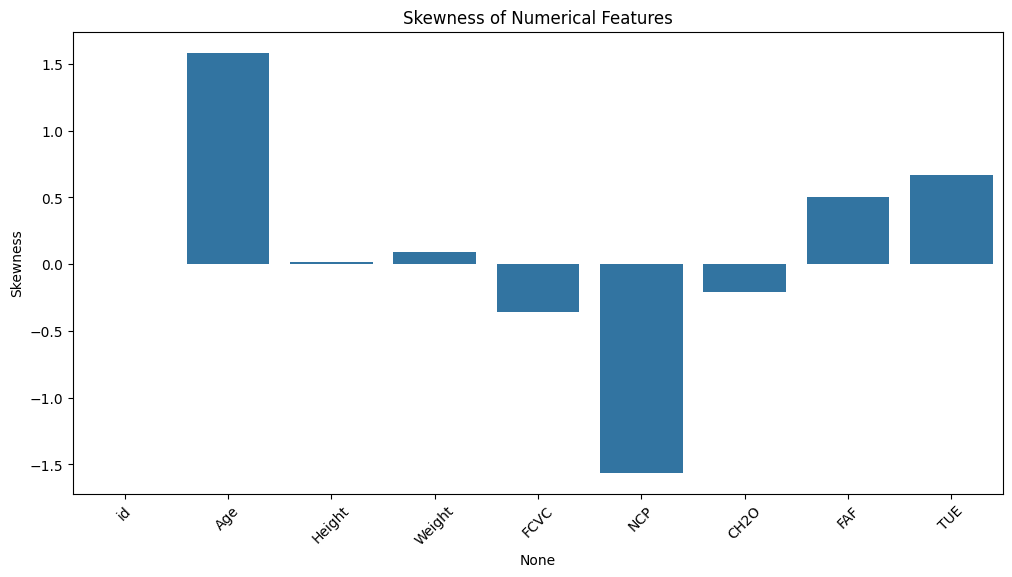

In [25]:
# Load dataset and do the nal
analyze_and_impute_missing_values(df)
analyze_data_biasness(df)

In [31]:
# Run analyses
analyze_decision_tree(X_train, X_test, y_train, y_test)
analyze_logistic_regression(X_train_scaled, X_test_scaled, y_train, y_test)
analyze_knn(X_train_scaled, X_test_scaled, y_train, y_test)

Decision Tree parameter tuning:
max_depth=3, min_samples_split=2 -> Accuracy: 0.7312, Precision: 0.6865, Recall: 0.7312, F1: 0.6929


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

max_depth=3, min_samples_split=5 -> Accuracy: 0.7312, Precision: 0.6865, Recall: 0.7312, F1: 0.6929
max_depth=3, min_samples_split=10 -> Accuracy: 0.7312, Precision: 0.6865, Recall: 0.7312, F1: 0.6929


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


max_depth=5, min_samples_split=2 -> Accuracy: 0.8343, Precision: 0.8467, Recall: 0.8343, F1: 0.8359
max_depth=5, min_samples_split=5 -> Accuracy: 0.8343, Precision: 0.8467, Recall: 0.8343, F1: 0.8359
max_depth=5, min_samples_split=10 -> Accuracy: 0.8343, Precision: 0.8467, Recall: 0.8343, F1: 0.8359
max_depth=10, min_samples_split=2 -> Accuracy: 0.8731, Precision: 0.8724, Recall: 0.8731, F1: 0.8726
max_depth=10, min_samples_split=5 -> Accuracy: 0.8733, Precision: 0.8729, Recall: 0.8733, F1: 0.8729
max_depth=10, min_samples_split=10 -> Accuracy: 0.8745, Precision: 0.8742, Recall: 0.8745, F1: 0.8742
max_depth=None, min_samples_split=2 -> Accuracy: 0.8425, Precision: 0.8427, Recall: 0.8425, F1: 0.8425
max_depth=None, min_samples_split=5 -> Accuracy: 0.8451, Precision: 0.8447, Recall: 0.8451, F1: 0.8447
max_depth=None, min_samples_split=10 -> Accuracy: 0.8572, Precision: 0.8563, Recall: 0.8572, F1: 0.8566

Best Decision Tree params: {'max_depth': 10, 'min_samples_split': 10} with metrics:


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=0.01, penalty=l2 -> Accuracy: 0.7671, Precision: 0.7555, Recall: 0.7671, F1: 0.7578


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=0.1, penalty=l2 -> Accuracy: 0.8418, Precision: 0.8381, Recall: 0.8418, F1: 0.8391


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=1, penalty=l2 -> Accuracy: 0.8685, Precision: 0.8671, Recall: 0.8685, F1: 0.8673


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=10, penalty=l2 -> Accuracy: 0.8726, Precision: 0.8714, Recall: 0.8726, F1: 0.8716

Best Logistic Regression params: {'C': 10, 'penalty': 'l2'} with metrics:
Accuracy: 0.8726
Precision: 0.8714
Recall: 0.8726
F1: 0.8716


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.95      0.92       505
      Normal_Weight       0.88      0.82      0.85       617
     Obesity_Type_I       0.81      0.85      0.83       582
    Obesity_Type_II       0.94      0.96      0.95       650
   Obesity_Type_III       1.00      1.00      1.00       809
 Overweight_Level_I       0.76      0.72      0.74       485
Overweight_Level_II       0.74      0.72      0.73       504

           accuracy                           0.87      4152
          macro avg       0.86      0.86      0.86      4152
       weighted avg       0.87      0.87      0.87      4152

KNN parameter tuning:
n_neighbors=3, weights=uniform, p=1 -> Accuracy: 0.7702, Precision: 0.7690, Recall: 0.7702, F1: 0.7663
n_neighbors=3, weights=uniform, p=2 -> Accuracy: 0.7394, Precision: 0.7375, Recall: 0.7394, F1: 0.7354
n_neighbors=3, weights=distance, p=1 -> Accuracy: 0.7784, Precision: 0.7758, Recall: 0.7784, F1: 0

{'accuracy': 0.7964836223506744,
 'precision': 0.7946003623508606,
 'recall': 0.7964836223506744,
 'f1': 0.7948738500623977}

Analyzing Decision Tree...
Decision Tree parameter tuning:
max_depth=3, min_samples_split=2 -> Accuracy: 0.7312, Precision: 0.6865, Recall: 0.7312, F1: 0.6929
max_depth=3, min_samples_split=5 -> Accuracy: 0.7312, Precision: 0.6865, Recall: 0.7312, F1: 0.6929


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

max_depth=3, min_samples_split=10 -> Accuracy: 0.7312, Precision: 0.6865, Recall: 0.7312, F1: 0.6929
max_depth=5, min_samples_split=2 -> Accuracy: 0.8343, Precision: 0.8467, Recall: 0.8343, F1: 0.8359
max_depth=5, min_samples_split=5 -> Accuracy: 0.8343, Precision: 0.8467, Recall: 0.8343, F1: 0.8359
max_depth=5, min_samples_split=10 -> Accuracy: 0.8343, Precision: 0.8467, Recall: 0.8343, F1: 0.8359
max_depth=10, min_samples_split=2 -> Accuracy: 0.8731, Precision: 0.8724, Recall: 0.8731, F1: 0.8726
max_depth=10, min_samples_split=5 -> Accuracy: 0.8733, Precision: 0.8729, Recall: 0.8733, F1: 0.8729
max_depth=10, min_samples_split=10 -> Accuracy: 0.8745, Precision: 0.8742, Recall: 0.8745, F1: 0.8742
max_depth=None, min_samples_split=2 -> Accuracy: 0.8425, Precision: 0.8427, Recall: 0.8425, F1: 0.8425
max_depth=None, min_samples_split=5 -> Accuracy: 0.8451, Precision: 0.8447, Recall: 0.8451, F1: 0.8447
max_depth=None, min_samples_split=10 -> Accuracy: 0.8572, Precision: 0.8563, Recall: 0.8

c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=0.01, penalty=l2 -> Accuracy: 0.7671, Precision: 0.7555, Recall: 0.7671, F1: 0.7578


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=0.1, penalty=l2 -> Accuracy: 0.8418, Precision: 0.8381, Recall: 0.8418, F1: 0.8391


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=1, penalty=l2 -> Accuracy: 0.8685, Precision: 0.8671, Recall: 0.8685, F1: 0.8673


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


C=10, penalty=l2 -> Accuracy: 0.8726, Precision: 0.8714, Recall: 0.8726, F1: 0.8716

Best Logistic Regression params: {'C': 10, 'penalty': 'l2'} with metrics:
Accuracy: 0.8726
Precision: 0.8714
Recall: 0.8726
F1: 0.8716


c:\Users\amitk\anaconda3\envs\adibits1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.95      0.92       505
      Normal_Weight       0.88      0.82      0.85       617
     Obesity_Type_I       0.81      0.85      0.83       582
    Obesity_Type_II       0.94      0.96      0.95       650
   Obesity_Type_III       1.00      1.00      1.00       809
 Overweight_Level_I       0.76      0.72      0.74       485
Overweight_Level_II       0.74      0.72      0.73       504

           accuracy                           0.87      4152
          macro avg       0.86      0.86      0.86      4152
       weighted avg       0.87      0.87      0.87      4152


Analyzing KNN...
KNN parameter tuning:
n_neighbors=3, weights=uniform, p=1 -> Accuracy: 0.7702, Precision: 0.7690, Recall: 0.7702, F1: 0.7663
n_neighbors=3, weights=uniform, p=2 -> Accuracy: 0.7394, Precision: 0.7375, Recall: 0.7394, F1: 0.7354
n_neighbors=3, weights=distance, p=1 -> Accuracy: 0.7784, Precision: 0.7758, Rec

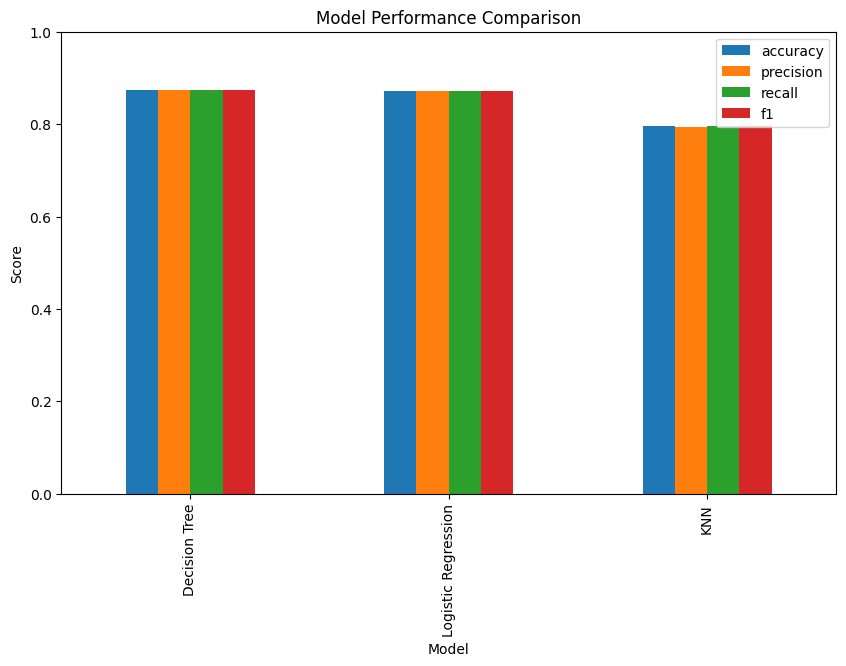


Recommended Model: Decision Tree
Recommended Model Metrics:
Accuracy: 0.8745
Precision: 0.8742
Recall: 0.8745
F1: 0.8742


In [29]:
compare_model_metrics(X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test)